In [1]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
#from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
#nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
dataset=pd.read_csv(r"C:\\Users\\Famin\\Desktop\\Capstone\\stock_data.csv",index_col=0)
dataset.head()



,Sentiment
Text,
"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
MNTA Over 12.00,1
OI Over 21.37,1


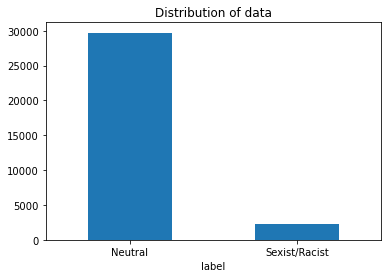

In [167]:
# Replacing the values to ease understanding.
# Plotting the distribution for dataset.
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Neutral','Sexist/Racist'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['tweet']), list(dataset['label'])

In [168]:
dataset['label'].value_counts()/dataset['label'].shape[0]

0    0.929854
1    0.070146
Name: label, dtype: float64

In [169]:
text

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation',
 '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ',
 ' @user camping tomorrow @user @user @user @user @user @user @user dannyâ\x80¦',
 "the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ ',
 " @user @user welcome here !  i'm   it's so #gr8 ! ",
 ' â\x86\x9d #ireland consume

In [170]:
dataset

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


In [171]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [172]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [173]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Preprocessing the data

In [174]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweet = expand_contractions(tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [175]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 6 seconds


In [176]:
processedtext[0]

'USER when father is dysfunctional and is so selfish he drag his kid into his dysfunction run '

# Splitting the data

In [177]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.05, random_state = 0)
print('Data Split done')

Data Split done


In [178]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  208358


In [179]:
vectoriser

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [180]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [181]:
X_train

<30363x208358 sparse matrix of type '<class 'numpy.float64'>'
	with 682826 stored elements in Compressed Sparse Row format>

# Evaluating Models

In [182]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1505
           1       0.00      0.00      0.00        94

    accuracy                           0.94      1599
   macro avg       0.47      0.50      0.48      1599
weighted avg       0.89      0.94      0.91      1599



C:\Users\siva\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


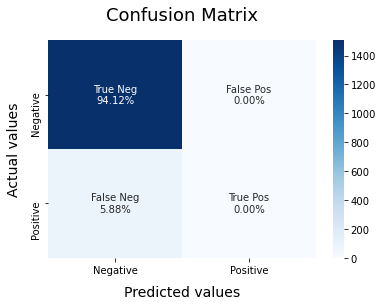

In [183]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1505
           1       0.87      0.65      0.74        94

    accuracy                           0.97      1599
   macro avg       0.92      0.82      0.87      1599
weighted avg       0.97      0.97      0.97      1599



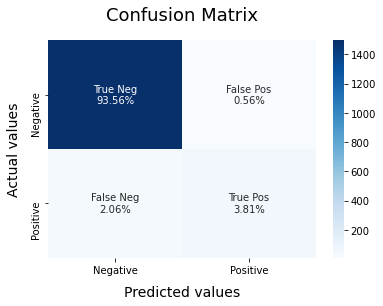

In [184]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

In [185]:
from sklearn.model_selection import cross_val_score,GridSearchCV


In [186]:
cv=cross_val_score(estimator=SVCmodel,X=X_train,y=y_train,scoring='f1',cv=10)
print(np.mean(cv))

0.6478579267035265


In [187]:
param= {'C': [0.1,1, 10, 100],'max_iter':[1000,10000,5000]}

GD=GridSearchCV(estimator=SVCmodel,param_grid=param,scoring='f1')
GD.fit(X_train,y_train)

C:\Users\siva\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'max_iter': [1000, 10000, 5000]},
             scoring='f1')

In [188]:
GD.best_estimator_

LinearSVC(C=100)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1505
           1       0.83      0.67      0.74        94

    accuracy                           0.97      1599
   macro avg       0.90      0.83      0.86      1599
weighted avg       0.97      0.97      0.97      1599



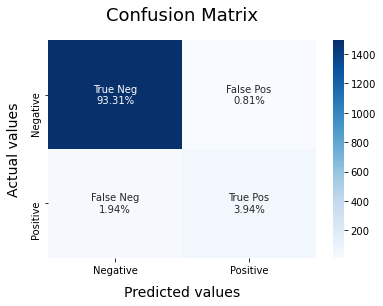

In [189]:
SVCmodel_t = LinearSVC(C=100)
SVCmodel_t.fit(X_train, y_train)
model_Evaluate(SVCmodel_t)

In [190]:
cv=cross_val_score(estimator=SVCmodel_t,X=X_train,y=y_train,scoring='f1',cv=10)
print(np.mean(cv))

C:\Users\siva\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.6941625308632572


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1505
           1       0.95      0.39      0.56        94

    accuracy                           0.96      1599
   macro avg       0.96      0.70      0.77      1599
weighted avg       0.96      0.96      0.96      1599



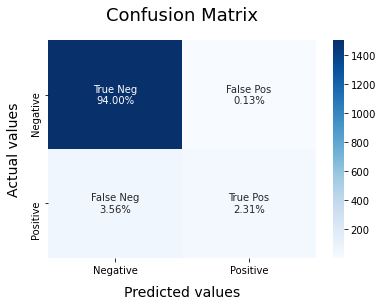

In [191]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [192]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [193]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    #df = df.replace([0,1], ["Neutral","Racist"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    test_data=pd.read_csv('test_tweets_anuFYb8 (1).csv')
    
    text = test_data['tweet']
    
    
    df = predict(vectoriser,  , text)
    print(df.head())
    

                                                text  sentiment
0  #studiolife #aislife #requires #passion #dedic...          0
1   @user #white #supremacists want everyone to s...          0
2  safe ways to heal your #acne!!    #altwaystohe...          0
3  is the hp and the cursed child book up for res...          0
4    3rd #bihday to my amazing, hilarious #nephew...          0


In [194]:
submission2=pd.concat([test_data['id'],df['sentiment']],axis=1)

In [195]:
submission2.rename({0:'id','sentiment':'label'},inplace=True,axis=1)

In [196]:
submission2.to_csv('submission2.csv',index=False)

In [197]:
submission2.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [198]:
test_data

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
